In [1]:
import warnings
warnings.filterwarnings('ignore')
import gensim

import matplotlib.pyplot as plt
%matplotlib inline
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler

from sklearn import preprocessing

dataPath = '../dataSet/'

In [2]:
# Step One. Read dataSet and do processing prepare works
train = pd.read_csv(dataPath+'age_train.csv', names=['uid','age'])
test = pd.read_csv(dataPath+'age_test.csv', names=['uid'])
basic_info = pd.read_csv(dataPath+'user_basic_info.csv', 
                        names=['uid','gender','city','phone_type','ram','ram_left','rom','rom_left','color','fontSize','ct','carrier','os'])

behavior_info = pd.read_csv(dataPath+'user_behavior_info.csv', 
                        names=['uid', 'times', 'A', 'B', 'C', 'D', 'E', 'F', 'G'])

app_package = pd.read_csv(dataPath+'user_app_actived.csv', names=['uid','appid'])
app_info = pd.read_csv(dataPath+'app_info.csv', names=['appid','category'])

e:\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
e:\python35\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
e:\python35\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains

[0.08497102 0.90322511 1.         0.53708812 0.53697542 0.01224214
 0.        ]


<BarContainer object of 7 artists>

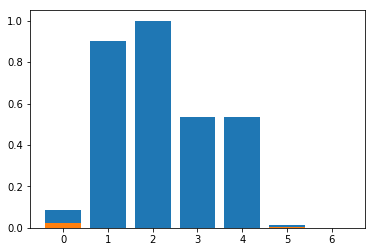

In [3]:
# Check seven user's behaviors populations and variances
sums = []
variance = []
chapters = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

for index in range(7):
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    # Scaling all behavior features into (0, 1)
    scale_res = scaler.fit_transform(behavior_info[chapters[index]])
    
    sums.append(np.sum(scale_res))
    variance.append(np.var(scale_res))

scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
scale_sum = scaler.fit_transform(sums)
print(scale_sum)

plt.bar(range(7), scale_sum)
plt.bar(range(7), variance)

In [4]:
# Do Tfidf to vectorize app's info
def get_app_str(df_input):
	result = ''
	for ele in df_input.split('#'):
		result += ele + ' '

	return result

app_package['appstr'] = app_package['appid'].apply(lambda x : get_app_str(x), 1)

# Do Tf-Idf Preparation
tfidf = CountVectorizer()

train_str_app = pd.merge(train[['uid']], app_package[['uid','appstr']],on='uid',how='left')
test_str_app = pd.merge(test[['uid']], app_package[['uid','appstr']],on='uid',how='left')
app_package['appstr'] = tfidf.fit_transform(app_package['appstr'])
train_app = tfidf.transform(list(train_str_app['appstr'])).tocsr()
test_app = tfidf.transform(list(test_str_app['appstr'])).tocsr()

all_id = pd.concat([train[['uid']], test[['uid']]])

all_id.index = range(len(all_id))

print(all_id.index)

RangeIndex(start=0, stop=2512500, step=1)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

train_feature = train_app
test_feature = test_app
n_folds = 5

df_stack = pd.DataFrame()
df_stack['uid'] = all_id['uid']

labels = train['age']

print('LR Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('LR Stacking: %d/%d' % ((i+1), n_folds))
	clf = LogisticRegression(random_state=100, C=8, n_jobs=4)
	clf.fit(train_feature[tr], labels[tr])
	score_va = clf.predict_proba(train_feature[va])[:,1]

	score_te = clf.predict_proba(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], clf.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_lr_classify_{}'.format('age')] = stack[:, 0]


print('SGD Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('SGD Stacking: %d/%d' % ((i+1), n_folds))
	sgd = SGDClassifier(random_state=100, loss='log', n_jobs=4)
	sgd.fit(train_feature[tr], labels[tr])
	score_va = sgd.predict_proba(train_feature[va])[:,1]

	score_te = sgd.predict_proba(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], sgd.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_sgd_classify_{}'.format('age')] = stack[:, 0]

print('PAC Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('PAC Stacking: %d/%d' % ((i+1), n_folds))
	pac = PassiveAggressiveClassifier(random_state=100, n_jobs=4)
	pac.fit(train_feature[tr], labels[tr])
	score_va = pac.predict_proba_lr(train_feature[va])[:,1]

	score_te = pac.predict_proba_lr(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], pac.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_pac_classify_{}'.format('age')] = stack[:, 0]

print('RidgeClassify Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('Ridge Stacking: %d/%d' % ((i+1), n_folds))
	ridge = RidgeClassifier(random_state=100, n_jobs=4)
	ridge.fit(train_feature[tr], labels[tr])
	score_va = ridge.predict_proba_lr(train_feature[va])[:,1]

	score_te = ridge.predict_proba_lr(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], ridge.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_ridge_classify_{}'.format('age')] = stack[:, 0]

print('BernoulliNB Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('BernoulliNB Stacking: %d/%d' % ((i+1), n_folds))
	bnb = BernoulliNB(n_jobs=4)
	bnb.fit(train_feature[tr], labels[tr])
	score_va = bnb.predict_proba(train_feature[va])[:,1]

	score_te = bnb.predict_proba(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], bnb.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_bnb_classify_{}'.format('age')] = stack[:, 0]

print('MultinomialNB Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('MultinomialNB Stacking: %d/%d' % ((i+1), n_folds))
	mnb = MultinomialNB(n_jobs=4)
	mnb.fit(train_feature[tr], labels[tr])
	score_va = mnb.predict_proba(train_feature[va])[:,1]

	score_te = mnb.predict_proba(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], mnb.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_mnb_classify_{}'.format('age')] = stack[:, 0]

print('LinerSVC Stacking')
stack_train = np.zeros((len(train), 1))
stack_test = np.zeros((len(test), 1))

score_va = 0

kfold = StratifiedKFold(n_splits=n_folds, random_state=100, shuffle=True)

for i, (tr, va) in enumerate(kfold.split(labels, labels)):
	print('LinerSVC Stacking: %d/%d' % ((i+1), n_folds))
	lsvc = LinerSVC(random_state=100, n_jobs=4)
	lsvc.fit(train_feature[tr], labels[tr])
	score_va = lsvc.predict_proba(train_feature[va])[:,1]

	score_te = lsvc.predict_proba(test_feature)[:,1]
	print('Score: ' + str(mean_squared_error(labels[va], lsvc.predict(train_feature[va]))))
	stack_train[va, 0] = score_va
	stack_test[:, 0] += score_te

stack_test /= n_folds
stack = np.vstack([stack_train, stack_test])

df_stack['pack_tfidf_lsvc_classify_{}'.format('age')] = stack[:, 0]

df_stack.to_csv(dataPath+'tfidf_classfiy_package.csv', index=None, encoding='utf8')
print('Primary Stacking is Done~')